In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy as np
import itertools
plt.style.use('seaborn')

## Bitonic sorting

### Definition: bitonic sequence
A bitonic sequence of length $n$ satisfies
$$ x_0 \le x_1 \le \dotsb \le x_k \ge x_{k+1} \ge \dotsb \ge x_{n-1} $$
**or a cyclic shift** thereof,
$$\hat x_i = x_{i+c \bmod n} .$$


sorting relies on the bitonic swapping operation,

In [42]:
def bitonic_split(x):
    L = len(x) // 2
    for i in range(L):    # each pair is independent
        if (x[i] > x[L + i]):
            x[i], x[L + i] = x[L + i], x[i]

after which the resulting subsequences `x[:L]` and `x[L:]` are bitonic and `max(x[:L]) <= min(x[L:])`. (It is beyond the scope of this class to formally prove this property, but we'll show examples.)

### Example

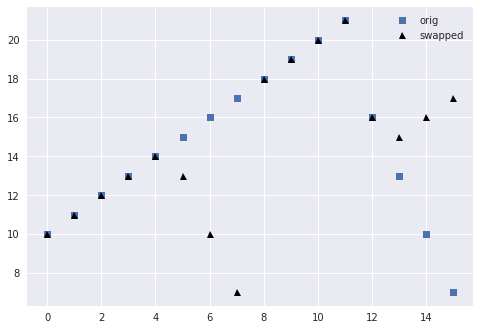

In [43]:
x = list(range(10, 22)) + [16, 13, 10, 7]
idx = np.arange(len(x))
plt.plot(x, 's', label='orig')
bitonic_split(x)
plt.plot(x, '^k', label='swapped')
plt.legend();

Note that the bitonic sequence on the right side is cyclicly permuted.

### Putting it together

![Bitonic sort from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/b/bd/BitonicSort1.svg)

* The blue blocks are forward bitonic merge networks, consisting of `bitonic_split` followed by recursive splits.
* The green blocks are reverse networks.
* The left half of the diagram constructs a global bitonic sequence that is increasing in the top half and decreasing in the bottom half. This bitonic sequence is balanced and not "shifted".
* The right half of the diagram merges a global bitonic sequence. The bitonic sequences produced in each stage of the merge may be unbalanced and/or cyclicly shifted.

### Demo

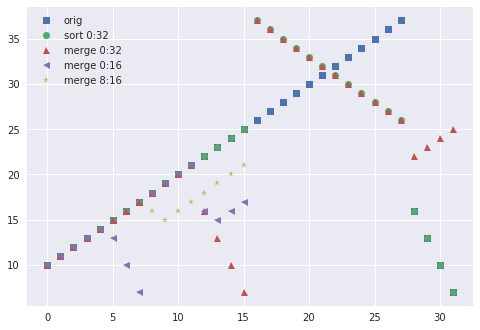

In [120]:
def bitonic_sort(up, x, start=0, end=None, plot=[]):
    if end is None:
        end = len(x)
    if end - start <= 1:
        return
    mid = start + (end - start) // 2
    bitonic_sort(True, x, start, mid)
    bitonic_sort(False, x, mid, end)
    if (start, end) in plot:
        bitonic_plot(x, start, end, 'sort')
    bitonic_merge(up, x, start, end, plot=plot)

def bitonic_merge(up, x, start, end, plot=False): 
    # assume input x is bitonic, and sorted list is returned 
    if end - start == 1:
        return
    bitonic_split2(up, x, start, end)
    if (start, end) in plot:
        bitonic_plot(x, start, end, 'merge')
    mid = start + (end - start) // 2
    bitonic_merge(up, x, start, mid, plot=plot)
    bitonic_merge(up, x, mid, end, plot=plot)

def bitonic_split2(up, x, start, end):
    L = (end - start) // 2
    for i in range(start, start + L):
        if (x[i] > x[L + i]) == up:
            x[i], x[L + i] = x[L + i], x[i] # swap

def bitonic_plot(x, start, end, phase):
    plt.plot(range(start, end), x[start:end], next(marker), label=f'{phase} {start}:{end}')
            
marker = itertools.cycle(['s', 'o', '^', '<', '*'])
x = list(range(10, 38)) + [16, 13, 10, 7]
plt.plot(x, next(marker), label='orig')
bitonic_sort(True, x, plot=[(0, 32), (0,16), (8,16)])
#plt.plot(x, next(marker), label='sorted')
plt.legend();

## Further resources on Sorting

* Chapter 9 of [Grama, Gupta, Karypis, Kumar (2003), **Introduction to Parallel Computing**](https://www-users.cs.umn.edu/~karypis/parbook/)
* [Grama slides](https://www-users.cs.umn.edu/~karypis/parbook/Lectures/AG/chap9_slides.pdf)

# Graphs

An (undirected) graph $(V, E)$ is a set of vertices $V$ and unordered pairs $(u,v) = (v,u) \in E$ of vertices $u,v \in V$.

Graphs are often expressed by their adjacency matrix of dimension $n\times n$ where $n = |V|$,
$$ A_{ij} = \begin{cases}
    1, & \text{if } (i,j) \in E \\
    0,              & \text{otherwise}
\end{cases}
$$

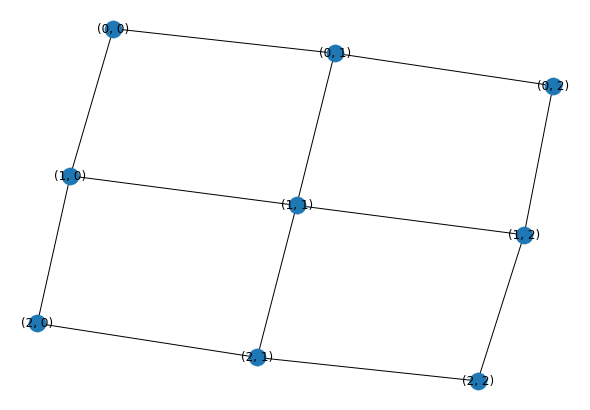

In [114]:
import networkx as nx

G = nx.grid_2d_graph(3, 3)
nx.draw(G, with_labels=True)

In [115]:
A = nx.adjacency_matrix(G)
A.todense()

matrix([[0, 1, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0]], dtype=int64)

### Compressed representation

Adjacency matrices often have many zeros so it's common to store a compressed representation.
We'll revisit such formats for sparse matrices.

In [107]:
A.indptr, A.indices

(array([ 0,  2,  5,  7, 10, 14, 17, 19, 22, 24], dtype=int32),
 array([1, 3, 0, 2, 4, 1, 5, 0, 4, 6, 1, 3, 5, 7, 2, 4, 8, 3, 7, 4, 6, 8,
        5, 7], dtype=int32))

In [112]:
for row in range(A.shape[0]):
    print(A.indices[A.indptr[row]:A.indptr[row+1]])

[1 3]
[0 2 4]
[1 5]
[0 4 6]
[1 3 5 7]
[2 4 8]
[3 7]
[4 6 8]
[5 7]


## Maximal independent set (MIS)

An independent set is a set of vertices $S \subset V$ such that $(u,v) \notin E$ for any pair $u,v \in S$.

In [64]:
mis = nx.maximal_independent_set(G)
mis

[(2, 0), (1, 2), (0, 0)]

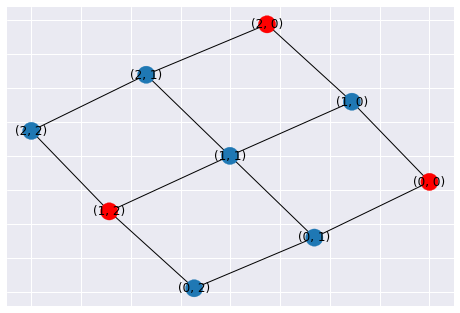

In [117]:
def plot_mis(G, mis):
    node_colors = ['red' if n in mis else '#1f78b4' for n in G.nodes()]
    nx.draw_networkx(G, node_color = node_colors)
plot_mis(G, mis)

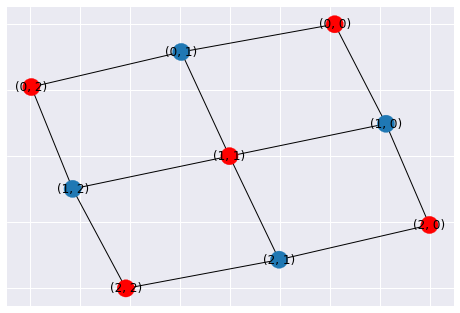

In [99]:
# Maximal independent sets are not unique
plot_mis(G, [(0,0), (0,2), (1,1), (2,0), (2,2)])

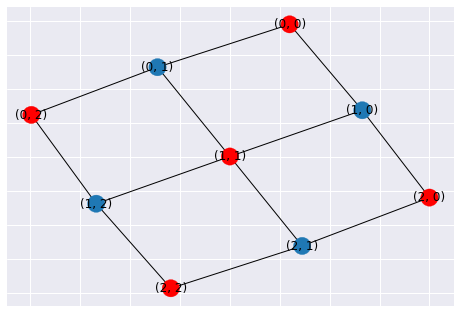

In [100]:
# We can coax the greedy algorithm to give a better MIS by specifying
# some nodes to include
plot_mis(G, nx.maximal_independent_set(G, [(1,1)]))

### Greedy Algorithms

1. Start with all vertices in candidate set $C = V$, empty $S$
2. While $C \ne \emptyset$: Choose a vertex $v \in C$
  * Add $v$ to $S$
  * Remove $v$ and all neighbors of $v$ from $C$

Algorithms differ in how they choose the next vertex $v \in C$.

### Tiebreaking

Suppose we index the vertices by integer and allow parallel selection of any $v$ for which
$$ v < \mathcal N(v) . $$

#### Hash variant

Consider a hash function $h(v)$ and allow any time

$$ h(v) < \min_{u\in \mathcal N(v)} h(u). $$

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


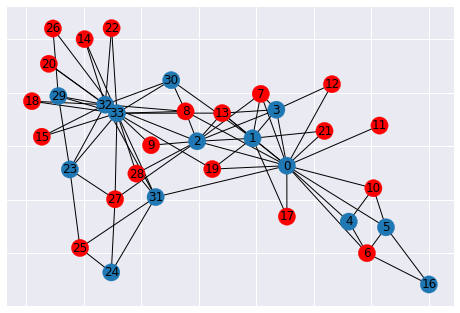

In [119]:
G = nx.karate_club_graph()
plot_mis(G, nx.maximal_independent_set(G))

## Further resources

* Chapter 10 of [Grama, Gupta, Karypis, Kumar (2003), **Introduction to Parallel Computing**](https://www-users.cs.umn.edu/~karypis/parbook/)
* [Grama slides](https://www-users.cs.umn.edu/~karypis/parbook/Lectures/AG/chap10_slides.pdf)